In [153]:
import numpy as np
import pandas as pd
from pandas import read_csv
from datetime import datetime
from numpy import mean
from numpy import std
import requests
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import TimeDistributed
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing as pre
from matplotlib import pyplot as plt
import datetime as dt
import quandl
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
# convert series to supervised learning
test_dataframes = {}
train_dataframes = {}
test_Open = {}
quandl.ApiConfig.api_key = 'NKL13i-RzgYty_HQNy7_'
data = ['BCHARTS/KRAKENUSD']
data1 = ['BCIW/_INX']
index = 1
for i in range(index):
    train_dataframes[i] = pd.DataFrame(quandl.get(data[i], start_date="'2017-01-01", end_date="2018-05-01"))
for j in range(index):
    test_dataframes[j] = pd.DataFrame(quandl.get(data[j], start_date="2017-01-01", end_date="2018-05-01"))
test_merged = test_dataframes[0]
test_Open = test_merged['Open']
test_Open.replace(0, np.nan, inplace=True)
test_Open = test_Open.mean(axis=0)
btc_test_dataframes = test_dataframes[0]
btc_test_Closed = btc_test_dataframes['Close']
btc_test_Closed.replace(0, np.nan, inplace=True)
btc_test_Closed = btc_test_Closed.mean(axis=0)
btc_test_dataframes['Avg Close'] = btc_test_Closed
btc_test_dataframes['Avg Open'] = test_Open
btc_test_dataframes.to_csv('outBTC.csv', index=False)

In [154]:
dataBCIW = pd.DataFrame(quandl.get("BCB/7809", start_date="2017-01-01", end_date="2018-05-01"))
dataHD = pd.DataFrame(quandl.get("EOD/HD", start_date="2017-01-01", end_date="2018-05-01"))
res = btc_test_dataframes['Close']
for i in range(btc_test_dataframes.shape[0]):
    res[i] = i+1
    
dowAndTime = pd.concat([res,dataBCIW], axis=1)
dowAndTime.to_csv('outDOWTIME.csv')
dataBCIW.to_csv('outDOW.csv', index=False)
#
training_set = pd.read_csv('outBTC.csv')  # reading csv file
df = pd.DataFrame(training_set['Close'])
training_set = df.fillna(df.mean())
#
res = pd.read_csv('outDOWTIME.csv')  # reading csv file
res = res.drop(columns=['Date'])
df1 = pd.DataFrame(res)
res = df1.fillna(df1.mean())
scale = MinMaxScaler()
y_training = scale.fit_transform(training_set)
x1,x2,y1,y2 = train_test_split(res,y_training,train_size=0.9, shuffle=False)
x31 = x2['Close']
x41 = []
for i in x31:
    x41.append([i])
    
x41 = scale.fit_transform(x41)
x1 = scale.fit_transform(x1)
x1 = x1.reshape((x1.shape[0], 1, x1.shape[1]))
x2 = scale.fit_transform(x2)
x21 = x2
x2 = x2.reshape((x2.shape[0], 1, x2.shape[1]))

In [155]:
regressor = Sequential()
regressor.add(LSTM(50, input_shape=(x1.shape[1], x1.shape[2])))
regressor.add(Dense(1))
regressor.compile(loss='mae', optimizer='adam')
history = regressor.fit(x1, y1, epochs=50, batch_size=72, validation_data=(x2, y2), verbose=2, shuffle=False)
predicted_price = regressor.predict(x2);

Train on 437 samples, validate on 49 samples
Epoch 1/50
 - 1s - loss: 0.1993 - val_loss: 0.3317
Epoch 2/50
 - 0s - loss: 0.1763 - val_loss: 0.3014
Epoch 3/50
 - 0s - loss: 0.1608 - val_loss: 0.2738
Epoch 4/50
 - 0s - loss: 0.1504 - val_loss: 0.2503
Epoch 5/50
 - 0s - loss: 0.1445 - val_loss: 0.2305
Epoch 6/50
 - 0s - loss: 0.1401 - val_loss: 0.2133
Epoch 7/50
 - 0s - loss: 0.1368 - val_loss: 0.1985
Epoch 8/50
 - 0s - loss: 0.1347 - val_loss: 0.1864
Epoch 9/50
 - 0s - loss: 0.1331 - val_loss: 0.1766
Epoch 10/50
 - 0s - loss: 0.1316 - val_loss: 0.1685
Epoch 11/50
 - 0s - loss: 0.1300 - val_loss: 0.1617
Epoch 12/50
 - 0s - loss: 0.1284 - val_loss: 0.1561
Epoch 13/50
 - 0s - loss: 0.1268 - val_loss: 0.1517
Epoch 14/50
 - 0s - loss: 0.1251 - val_loss: 0.1485
Epoch 15/50
 - 0s - loss: 0.1233 - val_loss: 0.1461
Epoch 16/50
 - 0s - loss: 0.1212 - val_loss: 0.1441
Epoch 17/50
 - 0s - loss: 0.1190 - val_loss: 0.1426
Epoch 18/50
 - 0s - loss: 0.1169 - val_loss: 0.1416
Epoch 19/50
 - 0s - loss: 0.

Standard deviation 0.13346916645025403
SAD: 8.993273612924309
SSD: 2.4966755436239105


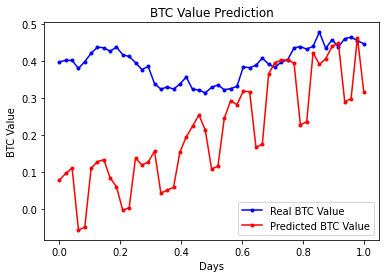

In [156]:
# Result on MatPlot
plt.plot(x41, y2, color='blue', label='Real BTC Value', marker='.')
plt.plot(x41, predicted_price, color='red', label='Predicted BTC Value', marker='.')
plt.title('BTC Value Prediction')
plt.xlabel('Days')
plt.ylabel('BTC Value')
plt.legend()
difference = (y2 - predicted_price)
print("Standard deviation", np.std(difference))
print("SAD:", np.sum(np.abs(difference)))
print("SSD:", np.sum(np.square(difference)))
plt.show()